# Q1: Scalar Computation Graph and Gradient

## TODO

In [0]:
import numpy as np
def g_w1(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    E = np.exp(-w1*x1-w2*x2)
    g = (x1*E)/(1+E)**2 + w1
    return g

def g_w2(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    E = np.exp(-w1*x1-w2*x2)
    g = (x2*E)/(1+E)**2 + w2
    return g

def g_x1(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    E = np.exp(-w1*x1-w2*x2)
    g = (w1*E)/(1+E)**2 
    return g

def g_x2(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    E = np.exp(-w1*x1-w2*x2)
    g = (w2*E)/(1+E)**2 
    return g

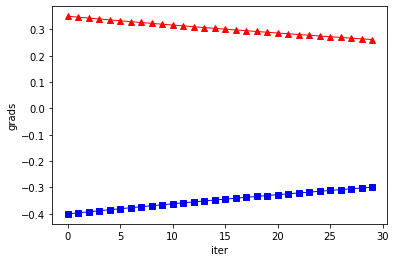

In [3]:
import matplotlib.pyplot as plt
x1 = 0.2
x2 = 0.4
w1 = 0.3
w2 = -0.5

grads_x1 = []
grads_x2 = []
grads_w1 = []
grads_w2 = []
w1s = [w1]
w2s = [w2]

for i in range(30):
    grad_w1 = g_w1(x1, x2, w1, w2)    
    grad_w2 = g_w2(x1, x2, w1, w2)
    
    w2 += -0.01 * grad_w2
    w1 += -0.01 * grad_w1
    
    w1s.append(w1)
    w2s.append(w2)

    grads_w1.append(grad_w1)
    grads_w2.append(grad_w2)
it=[i for i in range(30)]
plt.plot(it, grads_w1, color="r", linestyle="-", marker="^", linewidth=1)
plt.plot(it, grads_w2, color="b", linestyle="-", marker="s", linewidth=1)
plt.xlabel("iter")
plt.ylabel("grads")
plt.show()

# Q3: Neural Network From Scratch

In this section, we will implement a neural network to solve MNIST, a hand-written digits (0-9) classification dataset.

## Set up

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict
from functools import partial

from tqdm import tqdm
tqdm.monitor_interval = 0
tqdm = partial(tqdm, bar_format='{l_bar}{r_bar}')

import torch
import torch.nn.functional as F
import torchvision

In [0]:
TRAIN_SIZE = 50_000

train = torchvision.datasets.MNIST('./data', train=True, transform=None, target_transform=None, download=True)
test = torchvision.datasets.MNIST('./data', train=False, transform=None, target_transform=None, download=True)

train_x = train.data.float().numpy()
train_y = train.targets.numpy()

shuffle_idx = np.arange(len(train_x))
np.random.RandomState(0).shuffle(shuffle_idx)
train_x = train_x[shuffle_idx]
train_y = train_y[shuffle_idx]

dev_x, dev_y = train_x[TRAIN_SIZE:], train_y[TRAIN_SIZE:]
train_x, train_y = train_x[:TRAIN_SIZE], train_y[:TRAIN_SIZE]

test_x = test.data.float().numpy()
test_y = test.targets.numpy()

Sample of images



label = 0


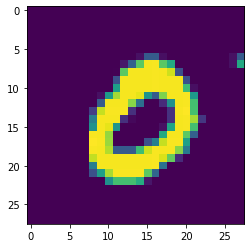

In [6]:
i = 4048 #@param {type: "slider", min: 0, max: 10000}
print(f'label = {train_y[i]}')
plt.imshow(train_x[i])
plt.show()

Each images have the same shape of 28-by-28. We flatten the matrix and pretend it is just one long vector.

In [0]:
NB_FEAT = 28 * 28

Normalize the feature. Note that we only use the training set to compute the mean and standard derivation.

In [0]:
mean = train_x.mean()
std = train_x.std()

train_x = (train_x - mean) / (std + 1e-7)
dev_x = (dev_x - mean) / (std + 1e-7)
test_x = (test_x - mean) / (std + 1e-7)

train_x = train_x.reshape(-1, NB_FEAT)
dev_x = dev_x.reshape(-1, NB_FEAT)
test_x = test_x.reshape(-1, NB_FEAT)

In [0]:
def row_logsumexp(x):
    # numerical stablization
    x_max = x.max(axis=1).reshape(-1, 1)
    return x_max + np.log(np.exp(x - x_max).sum(axis=1)).reshape(-1, 1)


In [0]:
class Parameters:
    def __init__(self):
        self.param: Dict[str, np.ndarray] = {}
        self.grad: Dict[str, np.ndarray] = {}

    def set_param(self, key: str, param: np.ndarray):
        self.param[key] = param
        self.grad[key] = np.zeros_like(param)

    def get_param(self, key):
        assert key in self.param, f'variable {key} is not part of the Parameter'
        return self.param[key]

    def accumlate_grad(self, key: str, grad: np.ndarray):
        assert key in self.param, f'variable {key} is not part of the Parameter'
        assert self.param[key].shape == grad.shape, f'for variable {key}, the shape of parameter and the shape of gradient is not matched'
        self.grad[key] += grad

    def zero_grad(self):
        for key in self.param:
            self.grad[key] = np.zeros_like(self.param[key])

    def apply_grad(self, lr: float):
        for key in self.param.keys():
            assert self.param[key].shape == self.grad[key].shape, f'for variable {key}, the shape of parameter and the shape of gradient is not matched'
            self.param[key] -= self.grad[key] * lr

In [0]:
def init_linear(input_dim, output_dim):
    return np.random.RandomState(0).randn(input_dim, output_dim) * np.sqrt(2 / input_dim)

In [0]:
def main_training(params: Parameters, forward_and_backward, train_x, train_y, dev_x, dev_y, batch_size, learning_rate, nb_epochs,acc_list):#@
    assert isinstance(params, Parameters)
    step = 0
    best_acc = 0
    for epoch in tqdm(range(nb_epochs)):
        train_loss = []
        lr = learning_rate
        for i in range(0, len(train_x), batch_size):
            batch_x = train_x[i:i+batch_size]
            batch_y = train_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params)
            params.apply_grad(lr)

            train_loss.append(loss)
            step += 1

        accs = []
        for i in range(0, len(dev_x), batch_size):
            batch_x = dev_x[i:i+batch_size]
            batch_y = dev_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params, grad=False)
            pred_y = probs.argmax(axis=1)
            accs.append(pred_y == batch_y)
        acc = np.mean(accs) * 100
        acc_list.append(float(acc))#@
        print(f'epoch {epoch} train loss = {np.mean(train_loss):.3f} dev accuracy = {acc:.2f}%')
        if acc > best_acc:
            best_acc = acc
  
    print(f'best dev accuracy = {best_acc:.2f}%')
    return acc_list#@

## Q2.1 Linear Classifier

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification. Note $N=28*28$ and $C=10$

In the softmax layer, $W_{sm} \in R^{N \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = x\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `linear_classifier_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
linear_classifier = Parameters()
linear_classifier.set_param('w_sm', init_linear(NB_FEAT, 10))

### TODO

In [0]:
def linear_classifier_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True) -> (float, np.ndarray):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and probs p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w_sm = param.get_param('w_sm')

    # compute loss and probs
    loss = 0
    probs = np.zeros((len(batch_x), 10))

    s = np.dot(batch_x,w_sm)
    s_exp = np.exp(s)
    probs = s_exp/np.sum(s_exp,axis=1,keepdims=True)
    log_probs = -np.log(probs[range(len(batch_x)),batch_y])
    loss = np.sum(log_probs)/len(batch_x)
    if not grad:
        return loss, probs

    # compute gradient
    w_sm_grad = np.zeros_like(w_sm)
    d_s = probs
    d_s[range(len(batch_x)),batch_y] -= 1
    d_s /= len(batch_x)
    w_sm_grad = np.dot(batch_x.T,d_s)

    # save the gradient
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs

### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = linear_classifier_forward_and_backward(batch_x, batch_y, linear_classifier)

w_sm = linear_classifier.get_param('w_sm')
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_logits = F.linear(_batch_x, _w_sm.T)
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()
#assert np.isclose(loss, _loss.item())
assert np.allclose(_w_sm.grad.numpy(), linear_classifier.grad['w_sm'])

### Training

In [16]:
BS = 50
LR = 0.005
NB_EPOCH = 20

linear_classifier = Parameters()
linear_classifier.set_param('w_sm', init_linear(NB_FEAT, 10))
acc_list0 = []
acc_list0= main_training(linear_classifier, linear_classifier_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH,acc_list0)


  5%|| 1/20 [00:01<00:24,  1.28s/it]

epoch 0 train loss = 0.619 dev accuracy = 87.97%


 10%|| 2/20 [00:02<00:21,  1.19s/it]

epoch 1 train loss = 0.380 dev accuracy = 89.59%


 15%|| 3/20 [00:03<00:18,  1.09s/it]

epoch 2 train loss = 0.347 dev accuracy = 90.25%


 20%|| 4/20 [00:03<00:16,  1.02s/it]

epoch 3 train loss = 0.330 dev accuracy = 90.87%


 25%|| 5/20 [00:04<00:14,  1.02it/s]

epoch 4 train loss = 0.318 dev accuracy = 91.14%


 30%|| 6/20 [00:05<00:13,  1.06it/s]

epoch 5 train loss = 0.310 dev accuracy = 91.33%


 35%|| 7/20 [00:06<00:12,  1.08it/s]

epoch 6 train loss = 0.304 dev accuracy = 91.48%


 40%|| 8/20 [00:07<00:10,  1.11it/s]

epoch 7 train loss = 0.299 dev accuracy = 91.57%


 45%|| 9/20 [00:08<00:09,  1.13it/s]

epoch 8 train loss = 0.295 dev accuracy = 91.60%


 50%|| 10/20 [00:09<00:08,  1.14it/s]

epoch 9 train loss = 0.292 dev accuracy = 91.68%


 55%|| 11/20 [00:10<00:07,  1.14it/s]

epoch 10 train loss = 0.289 dev accuracy = 91.79%


 60%|| 12/20 [00:10<00:06,  1.15it/s]

epoch 11 train loss = 0.286 dev accuracy = 91.80%


 65%|| 13/20 [00:11<00:06,  1.16it/s]

epoch 12 train loss = 0.284 dev accuracy = 91.78%


 70%|| 14/20 [00:12<00:05,  1.16it/s]

epoch 13 train loss = 0.281 dev accuracy = 91.79%


 75%|| 15/20 [00:13<00:04,  1.16it/s]

epoch 14 train loss = 0.280 dev accuracy = 91.79%


 80%|| 16/20 [00:14<00:03,  1.16it/s]

epoch 15 train loss = 0.278 dev accuracy = 91.82%


 85%|| 17/20 [00:15<00:02,  1.17it/s]

epoch 16 train loss = 0.276 dev accuracy = 91.88%


 90%|| 18/20 [00:15<00:01,  1.19it/s]

epoch 17 train loss = 0.275 dev accuracy = 91.86%


 95%|| 19/20 [00:16<00:00,  1.18it/s]

epoch 18 train loss = 0.273 dev accuracy = 91.86%


100%|| 20/20 [00:17<00:00,  1.18it/s]

epoch 19 train loss = 0.272 dev accuracy = 91.93%
best dev accuracy = 91.93%


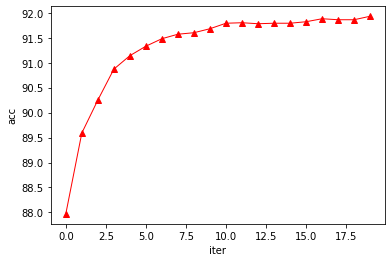

In [17]:
it=[i for i in range(NB_EPOCH)]
plt.plot(it, acc_list0, color="r", linestyle="-", marker="^", linewidth=1)
plt.xlabel("iter")
plt.ylabel("acc")
plt.show()

## Q2.1 MLP with Single Hidden Layer

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification.

For the first layer, $W_1 \in R^{N\times \frac{N}{2}}$ and $b_1 \in R^{\frac{N}{2}}$

$$\bar{h}_1 = x\cdot W_1 + b_1$$

$$h_1 = ReLU(\bar{h}_1)$$

In the softmax layer, $W_{sm} \in R^{\frac{N}{2} \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = h_1\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `mlp_single_hidden_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
mlp_single_hidden = Parameters()
mlp_single_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_single_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_single_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

### TODO



In [0]:
def mlp_single_hidden_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w1 = param.get_param('w1')
    b1 = param.get_param('b1')
    w_sm = param.get_param('w_sm')


    # compute loss and probs
    loss = 0
    probs = np.zeros((len(batch_x), 10))
    h1_hat = np.dot(batch_x,w1)+b1
    h1 = np.maximum(0,h1_hat)
    s = np.dot(h1,w_sm)
    s_exp = np.exp(s)
    probs = s_exp/np.sum(s_exp,axis = 1,keepdims =True)
    log_probs = -np.log(probs[range(len(batch_x)),batch_y])
    loss = np.sum(log_probs)/len(batch_x)

    if not grad:
        return loss, probs

    # compute gradient
    w1_grad = np.zeros_like(w1)
    b1_grad = np.zeros_like(b1)
    w_sm_grad = np.zeros_like(w_sm)
    d_s = probs
    d_s[range(len(h1)),batch_y] -= 1
    d_s /= len(h1)
    w_sm_grad = np.dot(h1.T,d_s)
    d_h1 = np.dot(d_s,w_sm.T)
    d_h1[h1<=0]=0
    w1_grad = np.dot(batch_x.T,d_h1)
    b1_grad = np.sum(d_h1,axis=0,keepdims=True)[0]

    param.accumlate_grad('w1', w1_grad)
    param.accumlate_grad('b1', b1_grad)
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs

### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = mlp_single_hidden_forward_and_backward(batch_x, batch_y, mlp_single_hidden)

w1 = mlp_single_hidden.get_param('w1')
b1 = mlp_single_hidden.get_param('b1')
w_sm = mlp_single_hidden.get_param('w_sm')
_w1 = torch.tensor(w1, dtype=torch.double, requires_grad=True)
_b1 = torch.tensor(b1, dtype=torch.double, requires_grad=True)
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_h1 = F.linear(_batch_x, _w1.T) + _b1
_h1 = F.relu(_h1)
_logits = F.linear(_h1, _w_sm.T)
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()

assert np.isclose(loss, _loss.item())
assert np.allclose(_w_sm.grad.numpy(), mlp_single_hidden.grad['w_sm'])
assert np.allclose(_w1.grad.numpy(), mlp_single_hidden.grad['w1'])
assert np.allclose(_b1.grad.numpy(), mlp_single_hidden.grad['b1'])

### Train!

In [21]:
BS = 50
LR = 0.005
NB_EPOCH = 20

mlp_single_hidden = Parameters()
mlp_single_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_single_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_single_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))
acc_list1 = []
acc_list1 =main_training(mlp_single_hidden, mlp_single_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH,acc_list1)

  5%|| 1/20 [00:08<02:36,  8.21s/it]

epoch 0 train loss = 0.533 dev accuracy = 90.39%


 10%|| 2/20 [00:16<02:27,  8.22s/it]

epoch 1 train loss = 0.293 dev accuracy = 92.34%


 15%|| 3/20 [00:24<02:20,  8.25s/it]

epoch 2 train loss = 0.244 dev accuracy = 93.34%


 20%|| 4/20 [00:32<02:11,  8.23s/it]

epoch 3 train loss = 0.214 dev accuracy = 94.07%


 25%|| 5/20 [00:41<02:03,  8.23s/it]

epoch 4 train loss = 0.193 dev accuracy = 94.39%


 30%|| 6/20 [00:49<01:55,  8.23s/it]

epoch 5 train loss = 0.177 dev accuracy = 94.76%


 35%|| 7/20 [00:57<01:46,  8.20s/it]

epoch 6 train loss = 0.163 dev accuracy = 95.08%


 40%|| 8/20 [01:05<01:38,  8.18s/it]

epoch 7 train loss = 0.152 dev accuracy = 95.35%


 45%|| 9/20 [01:13<01:29,  8.17s/it]

epoch 8 train loss = 0.142 dev accuracy = 95.55%


 50%|| 10/20 [01:22<01:22,  8.27s/it]

epoch 9 train loss = 0.134 dev accuracy = 95.79%


 55%|| 11/20 [01:30<01:14,  8.30s/it]

epoch 10 train loss = 0.126 dev accuracy = 95.94%


 60%|| 12/20 [01:38<01:06,  8.28s/it]

epoch 11 train loss = 0.119 dev accuracy = 96.07%


 65%|| 13/20 [01:47<00:58,  8.29s/it]

epoch 12 train loss = 0.113 dev accuracy = 96.15%


 70%|| 14/20 [01:56<00:50,  8.45s/it]

epoch 13 train loss = 0.108 dev accuracy = 96.26%


 75%|| 15/20 [02:04<00:42,  8.40s/it]

epoch 14 train loss = 0.103 dev accuracy = 96.40%


 80%|| 16/20 [02:12<00:33,  8.35s/it]

epoch 15 train loss = 0.098 dev accuracy = 96.52%


 85%|| 17/20 [02:20<00:25,  8.34s/it]

epoch 16 train loss = 0.094 dev accuracy = 96.57%


 90%|| 18/20 [02:29<00:16,  8.29s/it]

epoch 17 train loss = 0.090 dev accuracy = 96.63%


 95%|| 19/20 [02:37<00:08,  8.27s/it]

epoch 18 train loss = 0.087 dev accuracy = 96.66%


100%|| 20/20 [02:45<00:00,  8.26s/it]

epoch 19 train loss = 0.083 dev accuracy = 96.77%
best dev accuracy = 96.77%


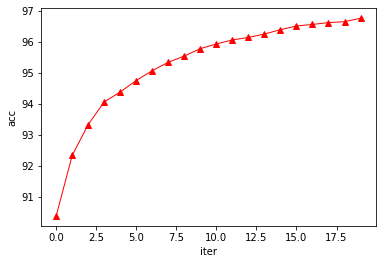

In [22]:
it=[i for i in range(NB_EPOCH)]
plt.plot(it, acc_list1, color="r", linestyle="-", marker="^", linewidth=1)
plt.xlabel("iter")
plt.ylabel("acc")
plt.show()

## Q2.3 MLP with Two Hidden Layer

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification.

For the first layer, $W_1 \in R^{N\times \frac{N}{2}}$ and $b_1 \in R^{\frac{N}{2}}$

$$\bar{h}_1 = x\cdot W_1 + b_1$$

$$h_1 = ReLU(\bar{h}_1)$$

For the second layer, $W_2 \in R^{\frac{N}{2} \times \frac{N}{2}}$ and $b_2 \in R^{\frac{N}{2}}$

$$\bar{h}_2 = h_1\cdot W_2 + b_2$$

$$h_2 = h_1 + ReLU(\bar{h}_2)$$

*Sidenote: in deep learning, $g(x, f) = x + f(x)$ is usually referred to as skip connection.*

In the softmax layer, $W_{sm} \in R^{\frac{N}{2} \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = h_2\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `mlp_two_hidden_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
mlp_two_hidden = Parameters()
mlp_two_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_two_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w2', init_linear(NB_FEAT // 2, NB_FEAT // 2))
mlp_two_hidden.set_param('b2', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

### TODO


In [0]:
def mlp_two_hidden_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w1 = param.get_param('w1')
    b1 = param.get_param('b1')
    w2 = param.get_param('w2')
    b2 = param.get_param('b2')
    w_sm = param.get_param('w_sm')

    # compute loss and probs
    loss = 0
    probs = np.zeros((len(batch_x), 10))
    h1_hat = np.dot(batch_x,w1)+b1
    h1 = np.maximum(0,h1_hat)
    h2_hat = np.dot(h1,w2)+b2
    h2_hat_relu = np.maximum(0,h2_hat)

    h2 = h1+h2_hat_relu
    s = np.dot(h2,w_sm)
    s_exp = np.exp(s)
    probs = s_exp/np.sum(s_exp,axis = 1,keepdims =True)
    log_probs = -np.log(probs[range(len(batch_x)),batch_y])
    loss = np.sum(log_probs)/len(batch_x)

    if not grad:
        return loss, probs

    # compute gradient
    w1_grad = np.zeros_like(w1)
    b1_grad = np.zeros_like(b1)
    w2_grad = np.zeros_like(w2)
    b2_grad = np.zeros_like(b2)
    w_sm_grad = np.zeros_like(w_sm)
    d_s = probs
    d_s[range(len(h2)),batch_y] -= 1
    d_s /= len(h2)
    w_sm_grad = np.dot(h2.T,d_s)
    d_h2 = np.dot(d_s,w_sm.T)
    d_h2_hat = d_h2
    d_h2_hat[h2_hat_relu<=0]=0
    w2_grad = np.dot(h1.T,d_h2_hat)
    b2_grad = np.sum(d_h2_hat,axis=0)
    d_h1 = np.dot(d_h2_hat,w2.T) + np.dot(d_s,w_sm.T)
    d_h1_hat= d_h1
    d_h1_hat[h1<=0] =0
    w1_grad = np.dot(batch_x.T,d_h1_hat)
    b1_grad = np.sum(d_h1_hat,axis=0)
    
    

    param.accumlate_grad('w1', w1_grad)
    param.accumlate_grad('b1', b1_grad)
    param.accumlate_grad('w2', w2_grad)
    param.accumlate_grad('b2', b2_grad)
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs


### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = mlp_two_hidden_forward_and_backward(batch_x, batch_y, mlp_two_hidden)

w1 = mlp_two_hidden.get_param('w1')
b1 = mlp_two_hidden.get_param('b1')
w2 = mlp_two_hidden.get_param('w2')
b2 = mlp_two_hidden.get_param('b2')
w_sm = mlp_two_hidden.get_param('w_sm')
_w1 = torch.tensor(w1, dtype=torch.double, requires_grad=True)
_b1 = torch.tensor(b1, dtype=torch.double, requires_grad=True)
_w2 = torch.tensor(w2, dtype=torch.double, requires_grad=True)
_b2 = torch.tensor(b2, dtype=torch.double, requires_grad=True)
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_h1 = F.linear(_batch_x, _w1.T) + _b1
_h1 = F.relu(_h1)

_h2 = F.linear(_h1, _w2.T) + _b2
_h2 = F.relu(_h2)
_h2 = _h2 + _h1

_logits = F.linear(_h2, _w_sm.T)
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()
assert np.isclose(loss, _loss.item())
assert np.allclose(_w_sm.grad.numpy(), mlp_two_hidden.grad['w_sm'])
assert np.allclose(_w2.grad.numpy(), mlp_two_hidden.grad['w2'])
assert np.allclose(_b2.grad.numpy(), mlp_two_hidden.grad['b2'])
assert np.allclose(_w1.grad.numpy(), mlp_two_hidden.grad['w1'])
assert np.allclose(_b1.grad.numpy(), mlp_two_hidden.grad['b1'])

### Train!

In [26]:
BS = 50
LR = 0.005
NB_EPOCH = 20

mlp_two_hidden = Parameters()
mlp_two_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_two_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w2', init_linear(NB_FEAT // 2, NB_FEAT // 2))
mlp_two_hidden.set_param('b2', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))
acc_list2 =[]
acc_list2 = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH,acc_list2)

  5%|| 1/20 [00:15<04:50, 15.30s/it]

epoch 0 train loss = 0.450 dev accuracy = 91.54%


 10%|| 2/20 [00:30<04:34, 15.27s/it]

epoch 1 train loss = 0.237 dev accuracy = 93.28%


 15%|| 3/20 [00:45<04:19, 15.26s/it]

epoch 2 train loss = 0.190 dev accuracy = 94.27%


 20%|| 4/20 [01:01<04:04, 15.29s/it]

epoch 3 train loss = 0.161 dev accuracy = 94.84%


 25%|| 5/20 [01:16<03:48, 15.26s/it]

epoch 4 train loss = 0.140 dev accuracy = 95.28%


 30%|| 6/20 [01:31<03:33, 15.23s/it]

epoch 5 train loss = 0.124 dev accuracy = 95.59%


 35%|| 7/20 [01:46<03:18, 15.27s/it]

epoch 6 train loss = 0.111 dev accuracy = 95.86%


 40%|| 8/20 [02:02<03:03, 15.26s/it]

epoch 7 train loss = 0.101 dev accuracy = 96.06%


 45%|| 9/20 [02:17<02:47, 15.22s/it]

epoch 8 train loss = 0.092 dev accuracy = 96.24%


 50%|| 10/20 [02:32<02:32, 15.20s/it]

epoch 9 train loss = 0.084 dev accuracy = 96.43%


 55%|| 11/20 [02:47<02:17, 15.23s/it]

epoch 10 train loss = 0.077 dev accuracy = 96.65%


 60%|| 12/20 [03:02<02:01, 15.24s/it]

epoch 11 train loss = 0.072 dev accuracy = 96.73%


 65%|| 13/20 [03:18<01:46, 15.23s/it]

epoch 12 train loss = 0.066 dev accuracy = 96.80%


 70%|| 14/20 [03:33<01:31, 15.23s/it]

epoch 13 train loss = 0.061 dev accuracy = 96.88%


 75%|| 15/20 [03:48<01:16, 15.29s/it]

epoch 14 train loss = 0.057 dev accuracy = 96.96%


 80%|| 16/20 [04:04<01:01, 15.42s/it]

epoch 15 train loss = 0.053 dev accuracy = 97.05%


 85%|| 17/20 [04:19<00:46, 15.41s/it]

epoch 16 train loss = 0.050 dev accuracy = 97.08%


 90%|| 18/20 [04:35<00:31, 15.57s/it]

epoch 17 train loss = 0.047 dev accuracy = 97.23%


 95%|| 19/20 [04:50<00:15, 15.45s/it]

epoch 18 train loss = 0.044 dev accuracy = 97.26%


100%|| 20/20 [05:06<00:00, 15.38s/it]

epoch 19 train loss = 0.041 dev accuracy = 97.29%
best dev accuracy = 97.29%


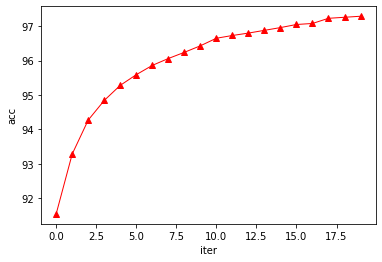

In [27]:
it=[i for i in range(NB_EPOCH)]
plt.plot(it, acc_list2, color="r", linestyle="-", marker="^", linewidth=1)
plt.xlabel("iter")
plt.ylabel("acc")
plt.show()

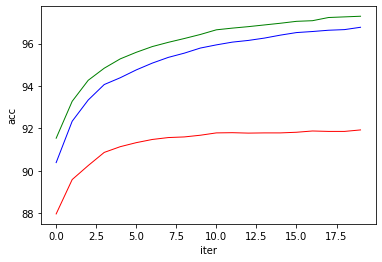

In [28]:
it=[i for i in range(NB_EPOCH)]
plt.plot(it, acc_list0, color="r", linestyle="-", linewidth=1,label='linear')
plt.plot(it, acc_list1, color="b", linestyle="-", linewidth=1,label='single hidden')
plt.plot(it, acc_list2, color="g", linestyle="-", linewidth=1,label='two hidden')
plt.xlabel("iter")
plt.ylabel("acc")
plt.show()

In [0]:
def para_training(params: Parameters, forward_and_backward, train_x, train_y, dev_x, dev_y, batch_size, learning_rate, nb_epochs):#@
    assert isinstance(params, Parameters)
    step = 0
    best_acc = 0
    for epoch in tqdm(range(nb_epochs)):
        train_loss = []
        lr = learning_rate
        for i in range(0, len(train_x), batch_size):
            batch_x = train_x[i:i+batch_size]
            batch_y = train_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params)
            params.apply_grad(lr)

            train_loss.append(loss)
            step += 1

        accs = []
        for i in range(0, len(dev_x), batch_size):
            batch_x = dev_x[i:i+batch_size]
            batch_y = dev_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params, grad=False)
            pred_y = probs.argmax(axis=1)
            accs.append(pred_y == batch_y)
        acc = np.mean(accs) * 100
        if acc > best_acc:
            best_acc = acc
    return best_acc

In [37]:
BS_list = [20,50]
LR_list = [0.001,0.005]
NB_EPOCH_list = [5,10]
listpara = [0,0,0,0]
best_acc = 0
for b in BS_list:
  for l in LR_list:
    for n in NB_EPOCH_list:
      acc = para_training(linear_classifier, linear_classifier_forward_and_backward, train_x, train_y, dev_x, dev_y, b, l, n)
      if acc > best_acc:
        best_acc =acc
        listpara[0] = b
        listpara[1] = l
        listpara[2] = n
        listpara[3] = 0
      acc = para_training(mlp_single_hidden, mlp_single_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, b, l, n)
      if acc > best_acc:
        best_acc =acc
        listpara[0] = b
        listpara[1] = l
        listpara[2] = n
        listpara[3] = 1
      acc = para_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, b, l, n)
      if acc > best_acc:
        best_acc =acc
        listpara[0] = b
        listpara[1] = l
        listpara[2] = n
        listpara[3] = 2
print(listpara)



100%|| 10/10 [02:28<00:00, 14.83s/it]

[20, 0.001, 5, 1]


When the batch size is 20, learning rate is 0.001 and the epoch is  5 , the accuracy of single hidden layer is the best

 20%|| 1/5 [00:28<01:55, 28.84s/it]

epoch 0 train loss = 0.001 dev accuracy = 98.17%


 40%|| 2/5 [00:57<01:26, 28.87s/it]

epoch 1 train loss = 0.001 dev accuracy = 98.17%


 60%|| 3/5 [01:26<00:57, 28.92s/it]

epoch 2 train loss = 0.001 dev accuracy = 98.17%


 80%|| 4/5 [01:55<00:28, 28.83s/it]

epoch 3 train loss = 0.001 dev accuracy = 98.17%


100%|| 5/5 [02:24<00:00, 28.76s/it]

epoch 4 train loss = 0.001 dev accuracy = 98.17%
best dev accuracy = 98.17%


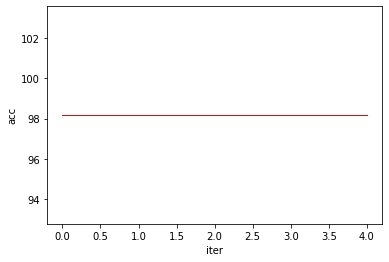

In [40]:
acc_list4 =[]
if listpara[3] ==0:
  acc_list4 = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, listpara[0], listpara[1], listpara[2],acc_list4)
if listpara[3] ==1:
  acc_list4 = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, listpara[0], listpara[1], listpara[2],acc_list4)
if listpara[3] ==2:
  acc_list4 = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, listpara[0], listpara[1], listpara[2],acc_list4)
it=[i for i in range(listpara[2])]
plt.plot(it, acc_list4, color="r", linestyle="-", linewidth=1,label='best')
plt.xlabel("iter")
plt.ylabel("acc")
plt.show()